In [1]:
from collections import Counter
import os

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from easydict import EasyDict as edict
from imutils.paths import list_images
from matplotlib import pyplot as plt
from torchvision import transforms
from sklearn.metrics import *
from torch import optim
from torch import nn
import pandas as pd
import numpy as np
import torch
import cv2

In [2]:
SEP       = os.path.sep
ROOT_PATH = SEP.join(os.getcwd().split(SEP)[:-4])
DATA_PATH = f'{ROOT_PATH}/Datasets/embryo'

In [3]:
class EmbryoDataset(Dataset):

    def __init__(self, image_paths, labels, dtype = 'train'):

        self.dtype       = dtype
        self.image_paths = image_paths
        self.labels      = labels


    def show_data_dist(self):

        lb_cnt   = Counter(self.labels)
        lb       = ['abnormal', 'normal']
        
        
        plt.bar(lb, lb_cnt.values())
        for k, v in lb_cnt.items():

            plt.text(k, v, v,
                     ha = 'center', va = 'bottom')


    def imread(self, image_path: str) -> np.array:

        image = cv2.imread(image_path, 0)
        return image


    def show_sample_images(self, n_samples = 3):

        _, axes    = plt.subplots(1, n_samples, figsize = (n_samples * 7, 5))
        random_idx = np.random.randint(0, len(self.image_paths), n_samples)

        for ax, idx in zip(axes, random_idx):

            image  = self.imread(self.image_paths[idx])
            lb     = self.labels[idx]

            ax.imshow(image, cmap = 'gray')
            ax.set_title(lb)
            ax.axis(False)
    

    def __len__(self):

        return len(self.image_paths)


    def __getitem__(self, idx):

        image_path = self.image_paths[idx]
        lb         = self.labels[idx]

        image              = self.imread(image_path)
        transform          = {}
        transform['train'] = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.ToTensor()
                            ])
        transform['test']  = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.ToTensor()
                            ])
        
        return transform[self.dtype](image), lb

        

In [4]:
label_extractor = lambda x: df[df.Image == x.split(SEP)[-1]].Class.to_list()[0]
train_paths     = sorted(list_images(f'{DATA_PATH}/train'))
df              = pd.read_csv(f'{DATA_PATH}/train.csv')
labels          = [label_extractor(path) for path in train_paths]
len(train_paths), len(labels)

(840, 840)

In [5]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
                                                        train_paths, labels, test_size = 0.2, shuffle = True,
                                                        random_state = 99, stratify = labels  
                                                    )

In [6]:
train_dataset = EmbryoDataset(train_paths, train_labels)
test_dataset  = EmbryoDataset(test_paths ,  test_labels, dtype = 'test')

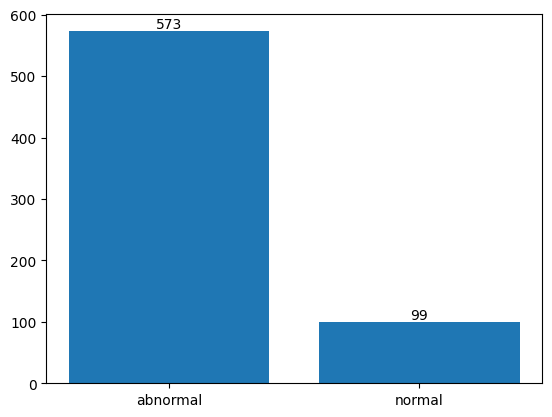

In [7]:
train_dataset.show_data_dist()

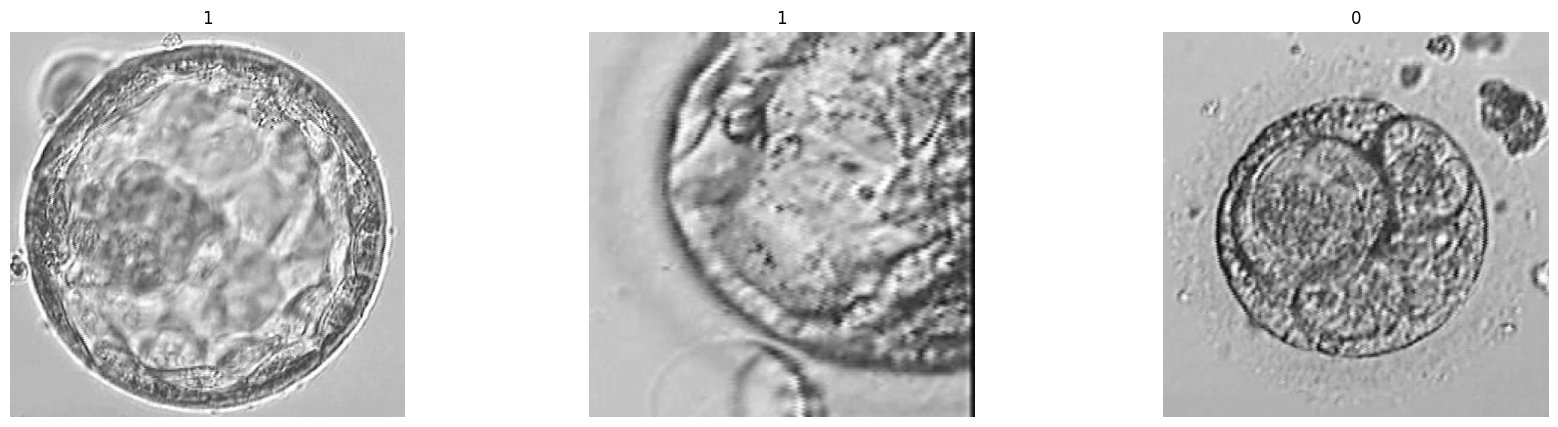

In [8]:
train_dataset.show_sample_images()